In [1]:
#Cell 1. Imports
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import time
import os
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from scipy.ndimage.measurements import label
from skimage.feature import hog
#from sklearn.cross_validation import train_test_split
# But, if you are using scikit-learn >= 0.18 then use this:
from sklearn.model_selection import train_test_split

In [2]:
# Define a class to receive the characteristics of each head detection
class HeatFrame():
    
    def __init__(self):
        self.avg_windows = 10
        # was the line detected in the last iteration?
        self.detected = False  
        
        #current heat frame
        self.current_box = []
        
        # x values of the last n fits of the line
        self.recent_boxes = [] 
        
        #average x values of the fitted line over the last n iterations
        self.best_box = []     
            
    def add_xbox(self,current_box):
        self.current_box=current_box
        self.recent_boxes.append(current_box.tolist())
        n_indices = min(len(self.recent_boxes),self.avg_windows)
        self.recent_boxes = self.recent_boxes[-n_indices:]
        self.best_box = np.sum(np.array(self.recent_boxes),axis = 0)

In [3]:
color_space = 'HLS' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 6  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 1 # HOG cells per block
hog_channel = 1 # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

In [4]:
#Cell 2.
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    example_img = mpimg.imread(car_list[0])
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = example_img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = example_img.dtype
    # Return data_dict
    return data_dict

In [5]:
#Cell 3
###### BE CAREFUL OF OVERFITTING DUE TO TIME-SERIES IMAGES #########
cars = glob.glob('vehicles/*/*/*.png')
notcars = glob.glob('non-vehicles/*/*/*.png')
        
data_info = data_look(cars, notcars)
print('Your function returned a count of', 
      data_info["n_cars"], ' cars and', 
      data_info["n_notcars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type:', 
      data_info["data_type"])

Your function returned a count of 8792  cars and 8968  non-cars
of size:  (64, 64, 3)  and data type: float32


In [6]:
#Cell 4. Color hist
#From Lesson 34, solutions
# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    #hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    #return hist_features
    return np.concatenate((channel1_hist[0], channel3_hist[0])) 
#saturation could be a good feature for cars

In [7]:
#Cell 5. 3d Plot
#Try experimenting with different color spaces such as LUV or HLS

from mpl_toolkits.mplot3d import Axes3D

def plot3d(pixels, colors_rgb,
        axis_labels=list("RGB"), axis_limits=((0, 255), (0, 255), (0, 255))):
    """Plot pixels in 3D."""

    # Create figure and 3D axes
    fig = plt.figure(figsize=(8, 8))
    ax = Axes3D(fig)

    # Set axis limits
    ax.set_xlim(*axis_limits[0])
    ax.set_ylim(*axis_limits[1])
    ax.set_zlim(*axis_limits[2])

    # Set axis labels and sizes
    ax.tick_params(axis='both', which='major', labelsize=14, pad=8)
    ax.set_xlabel(axis_labels[0], fontsize=16, labelpad=16)
    ax.set_ylabel(axis_labels[1], fontsize=16, labelpad=16)
    ax.set_zlabel(axis_labels[2], fontsize=16, labelpad=16)

    # Plot pixel values with colors given in colors_rgb
    ax.scatter(
        pixels[:, :, 0].ravel(),
        pixels[:, :, 1].ravel(),
        pixels[:, :, 2].ravel(),
        c=colors_rgb.reshape((-1, 3)), edgecolors='none')

    return ax  # return Axes3D object for further manipulation

In [8]:
#Cell 14, Lesson 21, Step 35, Solutions   
def convert_color(img, color_space='RGB'):
    if color_space != 'RGB':
        if color_space == 'HSV':
            return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: return np.copy(img)  

(720, 1280, 3)


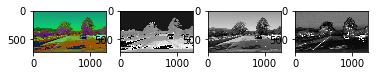

In [9]:
#Cell 6. Read a whole image
img = cv2.imread('test_image.jpg')
print(img.shape)

# Select a small fraction of pixels to plot by subsampling it
scale = max(img.shape[0], img.shape[1], 64) / 64  # at most 64 rows and columns
img_small = cv2.resize(img, (np.int(img.shape[1] / scale), np.int(img.shape[0] / scale)), interpolation=cv2.INTER_NEAREST)

# Convert subsampled image to desired color space(s)
img_small_RGB = cv2.cvtColor(img_small, cv2.COLOR_BGR2RGB)  # OpenCV uses BGR, matplotlib likes RGB
img_small_HSV = cv2.cvtColor(img_small, cv2.COLOR_BGR2HSV)
img_small_HLS = cv2.cvtColor(img_small, cv2.COLOR_BGR2HLS)
img_small_LUV = cv2.cvtColor(img_small, cv2.COLOR_BGR2LUV)
img_small_rgb = img_small_RGB / 255.  # scaled to [0, 1], only for plotting

# Plot and show
#plot3d(img_small_RGB, img_small_rgb)
#plt.show()

#plot3d(img_small_HSV, img_small_rgb, axis_labels=list("HSV"))
#plt.show()

#plot3d(img_small_HLS, img_small_rgb, axis_labels=list("HLS"))
#plt.show()

#plot3d(img_small_LUV, img_small_rgb, axis_labels=list("LUV"))
#plt.show()
test_img = convert_color(img, color_space)
fig = plt.figure()
plt.subplot(141)
plt.imshow(test_img)
plt.subplot(142)
plt.imshow(test_img[:,:,0],cmap = 'gray')
plt.subplot(143)
plt.imshow(test_img[:,:,1],cmap = 'gray')
plt.subplot(144)
plt.imshow(test_img[:,:,2],cmap = 'gray')

#figure = plt.figure()
#plt.imshow(img)
#plt.imshow(convert_color(img, color_space))

(64, 64, 3)


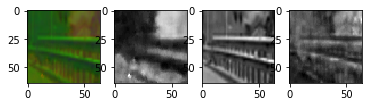

In [10]:
# Cell 7.  Read a notcar image
notcar_ind = np.random.randint(0, len(cars))
img = cv2.imread(notcars[notcar_ind])
#img = cv2.imread('non-vehicles/non-vehicles/Extras/extra2767.png')
print(img.shape)

# Select a small fraction of pixels to plot by subsampling it
scale = max(img.shape[0], img.shape[1], 64) / 64  # at most 64 rows and columns
img_small = cv2.resize(img, (np.int(img.shape[1] / scale), np.int(img.shape[0] / scale)), interpolation=cv2.INTER_NEAREST)

# Convert subsampled image to desired color space(s)
img_small_RGB = cv2.cvtColor(img_small, cv2.COLOR_BGR2RGB)  # OpenCV uses BGR, matplotlib likes RGB
img_small_HSV = cv2.cvtColor(img_small, cv2.COLOR_BGR2HSV)
img_small_HLS = cv2.cvtColor(img_small, cv2.COLOR_BGR2HLS)
img_small_LUV = cv2.cvtColor(img_small, cv2.COLOR_BGR2LUV)
img_small_rgb = img_small_RGB / 255.  # scaled to [0, 1], only for plotting

# Plot and show
#plot3d(img_small_RGB, img_small_rgb)
#plt.show()

#plot3d(img_small_HSV, img_small_rgb, axis_labels=list("HSV"))
#plt.show()

#plot3d(img_small_HLS, img_small_rgb, axis_labels=list("HLS"))
#plt.show()

#plot3d(img_small_LUV, img_small_rgb, axis_labels=list("LUV"))
#plt.show()

#figure = plt.figure()
#plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
test_img = convert_color(img, color_space)
fig = plt.figure()
plt.subplot(141)
plt.imshow(test_img)
plt.subplot(142)
plt.imshow(test_img[:,:,0],cmap = 'gray')
plt.subplot(143)
plt.imshow(test_img[:,:,1],cmap = 'gray')
plt.subplot(144)
plt.imshow(test_img[:,:,2],cmap = 'gray')

(64, 64, 3)


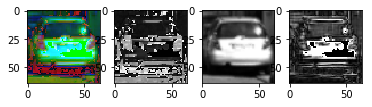

In [11]:
# Cell 8.  Read a car image
car_ind = np.random.randint(0, len(cars))
cars[car_ind]
#img = cv2.imread("test_images/test1.jpg")
img = cv2.imread(cars[car_ind])
print(img.shape)

# Select a small fraction of pixels to plot by subsampling it
scale = max(img.shape[0], img.shape[1], 64) / 64  # at most 64 rows and columns
img_small = cv2.resize(img, (np.int(img.shape[1] / scale), np.int(img.shape[0] / scale)), interpolation=cv2.INTER_NEAREST)

# Convert subsampled image to desired color space(s)
img_small_RGB = cv2.cvtColor(img_small, cv2.COLOR_BGR2RGB)  # OpenCV uses BGR, matplotlib likes RGB
img_small_HSV = cv2.cvtColor(img_small, cv2.COLOR_BGR2HSV)
img_small_HLS = cv2.cvtColor(img_small, cv2.COLOR_BGR2HLS)
img_small_LUV = cv2.cvtColor(img_small, cv2.COLOR_BGR2LUV)
img_small_rgb = img_small_RGB / 255.  # scaled to [0, 1], only for plotting

# Plot and show
#plot3d(img_small_RGB, img_small_rgb)
#plt.show()

#plot3d(img_small_HSV, img_small_rgb, axis_labels=list("HSV"))
#plt.show()

#plot3d(img_small_HLS, img_small_rgb, axis_labels=list("HLS"))
#plt.show()

#plot3d(img_small_LUV, img_small_rgb, axis_labels=list("LUV"))
#plt.show()

#figure = plt.figure()
#plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

#from Lesson 21, Step 20
#figure = plt.figure()
#plt.imshow(img_small_HLS[:,:,1],cmap = 'gray')
test_img = convert_color(img, color_space)
fig = plt.figure()
plt.subplot(141)
plt.imshow(test_img)
plt.subplot(142)
plt.imshow(test_img[:,:,0],cmap = 'gray')
plt.subplot(143)
plt.imshow(test_img[:,:,1],cmap = 'gray')
plt.subplot(144)
plt.imshow(test_img[:,:,2],cmap = 'gray')

In [12]:
#Cell 9 (from Lesson 21, Step 34, lesson_functions)
def bin_spatial(img, color_space='RGB', size=(32, 32)):
    # Convert image to new color space (if specified)
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)             
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(feature_image, size).ravel() 
    # Return the feature vector
    return features

In [13]:
# Cell 10.  Explore spatial features of the images  
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))
    
# Read in car / not-car images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])

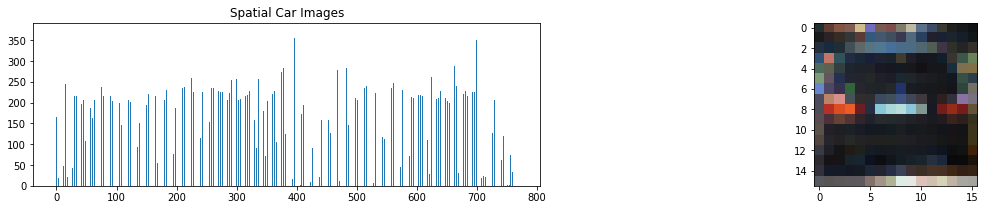

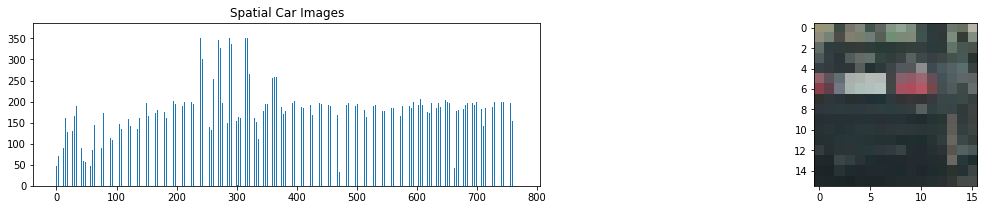

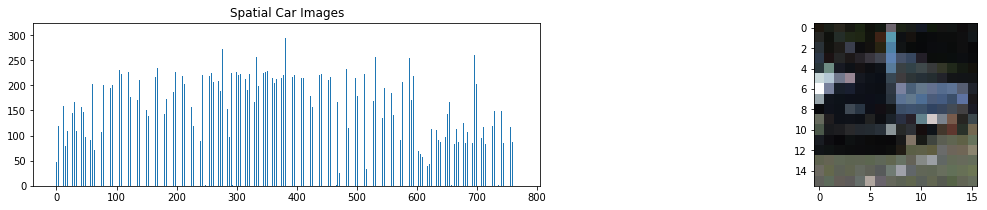

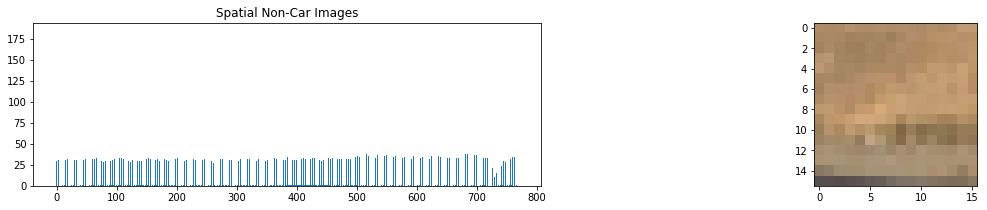

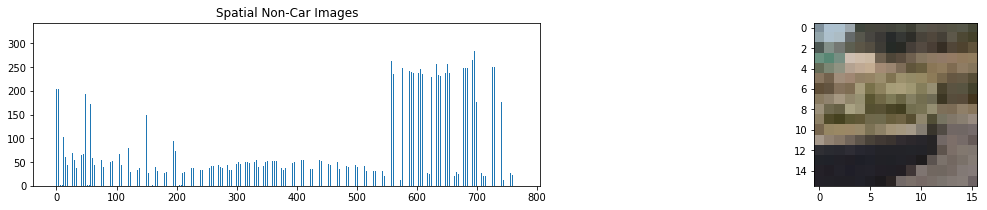

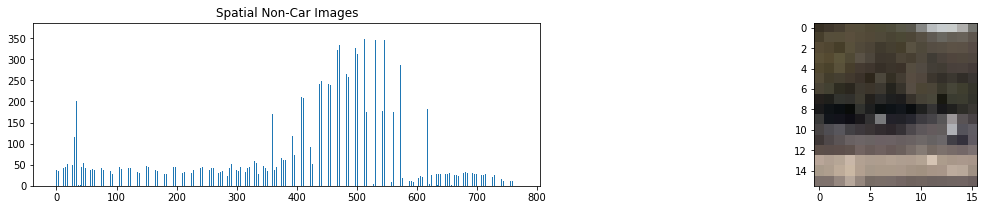

In [14]:
for ii in range(3):
    fig = plt.figure(figsize=(20,3))
    plt.subplot(121)
    car_ind = np.random.randint(0, len(cars))
    car_image = mpimg.imread(cars[car_ind])
    test_feat = bin_spatial(car_image, color_space, size=spatial_size)
    plt.bar(np.arange(len(test_feat)),test_feat)
    plt.ylim((0,1.1 * max(test_feat)))
    plt.title('Spatial Car Images')
    plt.subplot(122)
    plt.imshow(cv2.resize(car_image, spatial_size))
    
for ii in range(3):
    fig = plt.figure(figsize=(20,3))
    plt.subplot(121)
    notcar_ind = np.random.randint(0, len(notcars))
    notcar_image = mpimg.imread(notcars[notcar_ind])
    test_feat = bin_spatial(notcar_image, color_space, size=spatial_size)
    plt.bar(np.arange(len(test_feat)),test_feat)
    plt.ylim((0,1.1 * max(test_feat)))
    plt.title('Spatial Non-Car Images')
    plt.subplot(122)
    plt.imshow(cv2.resize(notcar_image, spatial_size))

In [15]:
#Cell 11. Get HOG features (From Lesson 21, Step 29)
# Define a function to return HOG features and visualization 
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), block_norm= 'L2-Hys',
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), block_norm= 'L2-Hys',
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

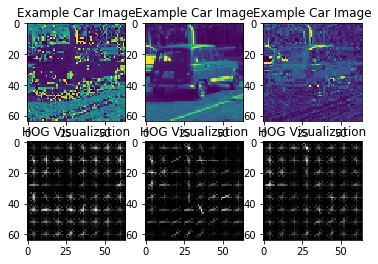

In [16]:
#Cell 12.  Visualize the HOG feature of a car
img = cv2.imread(cars[car_ind])
img_small = cv2.resize(img, (np.int(img.shape[1] / scale), np.int(img.shape[0] / scale)), interpolation=cv2.INTER_NEAREST)
img_small = convert_color(img_small, color_space)
hog_images = []
for ii in range(3):
    features, hog_image = get_hog_features(img_small[:,:,ii], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
    hog_images.append(hog_image)
fig = plt.figure()
plt.subplot(231)
plt.imshow(img_small[:,:,0])
plt.title('Example Car Image')
plt.subplot(232)
plt.imshow(img_small[:,:,1])
plt.title('Example Car Image')
plt.subplot(233)
plt.imshow(img_small[:,:,2])
plt.title('Example Car Image')
plt.subplot(234)
plt.imshow(hog_images[0], cmap='gray')
plt.title('HOG Visualization')
plt.subplot(235)
plt.imshow(hog_images[1], cmap='gray')
plt.title('HOG Visualization')
plt.subplot(236)
plt.imshow(hog_images[2], cmap='gray')
plt.title('HOG Visualization')

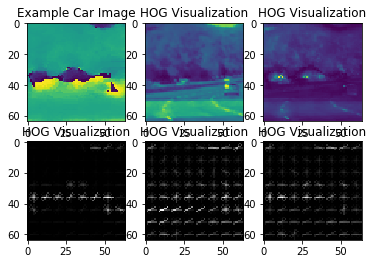

In [17]:
#Cell 13.  Visualize the HOG feature of a notcar
#img = cv2.imread('non-vehicles/non-vehicles/Extras/extra2767.png')
img = cv2.imread(notcars[notcar_ind])
img_small = cv2.resize(img, (np.int(img.shape[1] / scale), np.int(img.shape[0] / scale)), interpolation=cv2.INTER_NEAREST)
img_small = convert_color(img_small, color_space)

hog_images = []
for ii in range(3):
    features, hog_image = get_hog_features(img_small[:,:,ii], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
    hog_images.append(hog_image)
fig = plt.figure()
plt.subplot(231)
plt.imshow(img_small[:,:,0])
plt.title('Example Car Image')
plt.subplot(232)
plt.imshow(img_small[:,:,1])
plt.title('HOG Visualization')
plt.subplot(233)
plt.imshow(img_small[:,:,2])
plt.title('HOG Visualization')
plt.subplot(234)
plt.imshow(hog_images[0], cmap='gray')
plt.title('HOG Visualization')
plt.subplot(235)
plt.imshow(hog_images[1], cmap='gray')
plt.title('HOG Visualization')
plt.subplot(236)
plt.imshow(hog_images[2], cmap='gray')
plt.title('HOG Visualization')

In [18]:
# Cell 13. Combine and Normalize Features (From Lesson 21, Step 34, solutions)
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

In [19]:
#Cell 15, Lesson 21, Step 35, Solutions
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space, img_return = False, hog_channel = 0):
     
    #use this conversion if the image read is a jpg
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, color_space)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    found_boxes = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            #hog_features = hog_feat2
            if hog_channel == 'ALL':
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            elif hog_channel == 0:
                hog_features = hog_feat1
            elif hog_channel == 1:
                hog_features = hog_feat2
            elif hog_channel == 2:
                hog_features = hog_feat3

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
    
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                found_boxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6)
    
    if img_return:
        return draw_img, found_boxes
    else:
        return found_boxes    

In [20]:
#Cell 16
#Multiple Detections and False Positives
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

features
54.05 Seconds to extract HOG features...
Length car features:1184
[  1.29785706e+02   1.53431386e-01   7.36036003e-02 ...,   9.03648710e+00
   1.39029407e+01   3.78329048e+01]
labels
split
scale
Using: 6 orientations 8 pixels per cell and 1 cells per block
Feature vector length: 1184


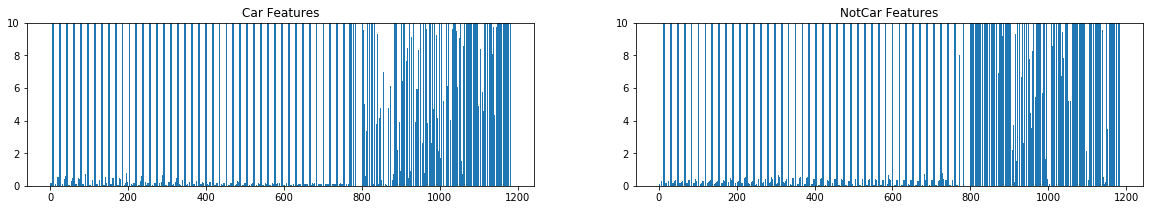

In [21]:
#Cell 17. Extract features and visualize the feature vector for one image of car and one image of notcar
from random import shuffle
shuffle(cars)
shuffle(notcars)
if 0:
    sample_size = 500
    cars = cars[0:sample_size]
    notcars = notcars[0:sample_size]

#Extract Features
print('features')
t=time.time()
car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')

print('Length car features:' + str(len(car_features[0])))
print(car_features[0])
fig = plt.figure(figsize=(20,3))
plt.subplot(121)
plt.bar(np.arange(len(car_features[0])),car_features[0])
plt.ylim((0,10))
plt.title('Car Features')
plt.subplot(122)
plt.bar(np.arange(len(notcar_features[0])),notcar_features[0])
plt.ylim((0,10))
plt.title('NotCar Features')

print('labels')
# Define a labels vector based on features lists
y = np.hstack((np.ones(len(car_features)), 
              np.zeros(len(notcar_features))))

X = np.vstack((car_features, notcar_features)).astype(np.float64)

print('split')
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)

print('scale')
# Fit a per-column scaler only on the training data
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to both X_train and X_test
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

In [22]:
#Cell 18.  Build the classifier

# search for a) kernel b) gamma and c) C value to minimize prediction error. 
# use scikit-learn parameter tuning algorithms
# for a non-linear kernel, you can tune C and gamma
# use GridSearchCV 


if 1:
    # Use a linear SVC (support vector classifier)
    t=time.time()
    clf = svm.SVC(kernel = 'linear', C = 10)
    # Train the SVC
    clf.fit(X_train, y_train)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train SVC...')
else:
    #EXHAUSTIVE SEARCH
    print('1')
    t=time.time()
    print('2')
    svc = svm.SVC()
    print('3')
    parameters = {'kernel':['rbf'], 'C':[1, 10, 100], 'gamma': [1/1968.0, 10/1968.0, 1000/1968.0]}
    print('4')
    clf = GridSearchCV(svc, parameters)
    print('5')
    clf.fit(X_train, y_train)
    print('6')
    t2 = time.time()
    print('7')
    print(round(t2-t, 2), 'Seconds to train SVC...')
    #clf.best_params_ to get the best parameters in a dict
    print(clf.best_params_)
    print(clf.best_params_.items())
    #{'kernel': 'rbf', 'C': 2}
    #dict_items([('kernel', 'rbf'), ('C', 2)])

53.08 Seconds to train SVC...


In [23]:
#Cell 19.

#Check the score of the SVC
print('Test Accuracy of SVC = ', round(clf.score(X_test, y_test), 4))
# Check the prediction time for a single sample

image = mpimg.imread('video_diag/frame542.jpg')
draw_image = np.copy(image)

#Perform the search and classification for different areas of the image
param_list = [(380,500,1.0), (400,656,1.5), (400,700,4.5)]
all_boxes = []
images_out = []
img_return=True
for param in param_list:
    image_out, box_out = find_cars(image, param[0], param[1], param[2], clf, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space, img_return, hog_channel)
    all_boxes.extend(box_out)
    images_out.append(image_out)
    
print(all_boxes)
heat = np.zeros_like(image[:,:,0]).astype(np.float)
# Add heat to each box in box list
heat = add_heat(heat,all_boxes)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,2)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)

Test Accuracy of SVC =  0.9575
[((160, 428), (224, 492)), ((272, 412), (336, 476)), ((272, 428), (336, 492)), ((288, 428), (352, 492)), ((336, 396), (400, 460)), ((896, 412), (960, 476)), ((912, 396), (976, 460)), ((912, 412), (976, 476)), ((928, 412), (992, 476)), ((928, 428), (992, 492)), ((944, 412), (1008, 476)), ((960, 412), (1024, 476)), ((0, 424), (96, 520)), ((0, 472), (96, 568)), ((24, 472), (120, 568)), ((24, 496), (120, 592)), ((72, 448), (168, 544)), ((72, 472), (168, 568)), ((72, 496), (168, 592)), ((144, 520), (240, 616)), ((168, 496), (264, 592)), ((192, 448), (288, 544)), ((240, 448), (336, 544)), ((240, 544), (336, 640)), ((264, 424), (360, 520)), ((264, 448), (360, 544)), ((264, 472), (360, 568)), ((264, 496), (360, 592)), ((264, 544), (360, 640)), ((288, 424), (384, 520)), ((288, 472), (384, 568)), ((288, 544), (384, 640)), ((312, 544), (408, 640)), ((360, 472), (456, 568)), ((384, 544), (480, 640)), ((408, 472), (504, 568)), ((408, 496), (504, 592)), ((456, 424), (5

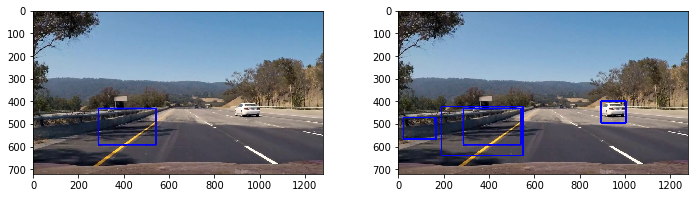

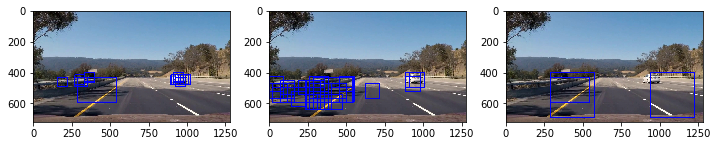

In [24]:
#Cell 20.  Plot the original, final and the contributors to the final
fig = plt.figure(figsize=(12,3))
plt.subplot(121)
plt.imshow(image)
plt.subplot(122)
plt.imshow(draw_img)

fig = plt.figure(figsize=(12,3))
plt.subplot(131)
plt.imshow(images_out[0])
plt.subplot(132)
plt.imshow(images_out[1])
plt.subplot(133)
plt.imshow(images_out[2])

In [25]:
#Video Pipeline
def process_image(img_from_vid):
    
    param_list = [(380,500,1.0), (400,656,1.5), (400,700,4.5)]
    all_boxes = []
    img_return=False
    for param in param_list:
        all_boxes.extend(find_cars(img_from_vid, param[0], param[1], param[2], clf, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space,img_return, hog_channel))
    #draw the boxes
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat,all_boxes)
    heat = apply_threshold(heat, 4)
    fig = plt.figure()
    plt.subplot(141)
    plt.imshow(heat)
    heat_img.add_xbox(heat)
    plt.subplot(142)
    plt.imshow(heat_img.best_box)
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat_img.best_box,20)
    plt.subplot(143)
    plt.imshow(heat)
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    plt.subplot(144)
    plt.imshow(heatmap)
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    return draw_labeled_bboxes(np.copy(img_from_vid), labels)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18


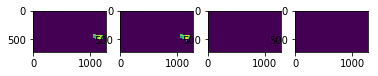

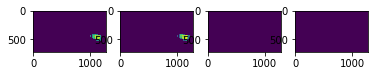

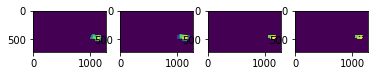

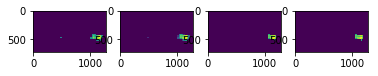

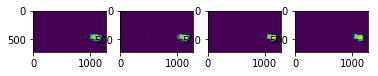

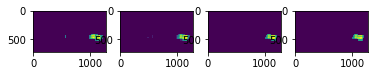

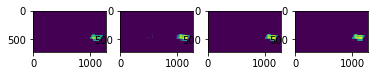

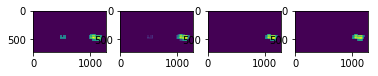

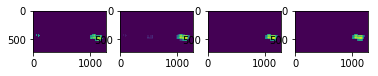

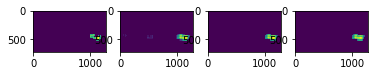

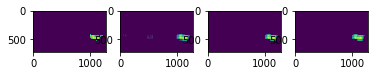

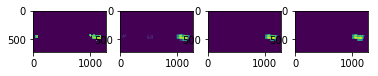

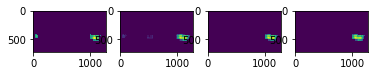

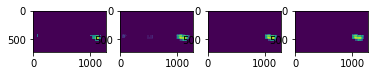

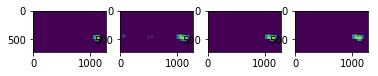

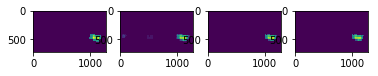

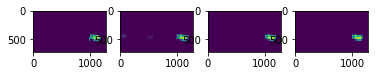

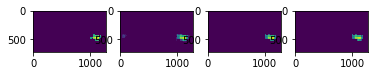

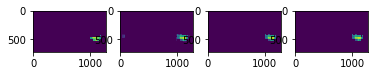

In [26]:
heat_img = HeatFrame()
test_vid_imgs = glob.glob('video_diag_small/*.jpg')
pathOut = 'output_images'
for count in range(len(test_vid_imgs)):
    test_vid_img_out = process_image(mpimg.imread(test_vid_imgs[count]))
    cv2.imwrite(os.path.join(pathOut, "frame{:d}.jpg".format(count)), test_vid_img_out)
    print(count)

In [ ]:
#Cell 15
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [ ]:
#Video Processing
#Cell 18
project_output = 'test_videos_output/project.mp4'

## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip("project_video.mp4").subclip(30,35)
clip1 = VideoFileClip("project_video.mp4")
project_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time project_clip.write_videofile(project_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/project.mp4
[MoviePy] Writing video test_videos_output/project.mp4


 42%|█████████████████████████████████▏                                             | 529/1261 [25:58<41:04,  3.37s/it]

In [ ]:
def extractFrames(pathIn, pathOut):
    os.mkdir(pathOut)
    cap = cv2.VideoCapture(pathIn)
    count = 0
    
    print(cap.isOpened())
 
    while (cap.isOpened()):
 
        # Capture frame-by-frame
        ret, frame = cap.read()
        print(ret)
 
        if ret == True:
            print('Read %d frame: ' % count, ret)
            cv2.imwrite(os.path.join(pathOut, "frame{:d}.jpg".format(count)), frame)  # save frame as JPEG file
            count += 1
        else:
            break
 
    # When everything done, release the capture
    cap.release()
    cv2.destroyAllWindows()
    
#extractFrames('test_videos_output/project.mp4', 'video_diag')